# Exercises Week 10-11: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import math
import seaborn as sns



**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.  
We very strongly advise each member of the group to work on the whole notebook on their own to understand it in details, as it comes out that in the exam this subject is often poorly understood.  
The theory related to Exercise 2 Question 2 will be discussed in the lecture of 27th November.**

### Exercise 1: Simulation of cell cycle gene (RNA) expression

In this exercise, we focus on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE) with **time-dependent** transcription and degradation rates to model cell cycle dynamics.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. The frequency is defined by $\omega=\frac{2\pi}{T}$, taking a cell cycle period $T=20h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a periodic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a periodic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with periodic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

In [28]:
def production_decay_ode(y, time,rho,T,s0,eps_s,k0,eps_k,tk):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    k_t: mRNA degradation rate
    s_t: pre-mRNA transcription rate
    rho: splicing rate
    T: cell cycle period
    """
    
    P, M = y
    omega = 2*np.pi / T

    s_t = s0 * (1 + eps_s * np.cos(omega * time))
    k_t = k0 * (1 + eps_k * np.cos(omega * (time - tk)))

    dPdt = s_t - rho * P
    dMdt = rho * P - k_t * M
    return [dPdt, dMdt] 


def simulation(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """

    rho = parameters['rho']
    T = parameters['T']
    
    s0 = parameters['s0']
    eps_s = parameters['eps_s']
    k0 = parameters['k0']
    eps_k = parameters['eps_k']
    rho = parameters['rho']
    tk = parameters['tk']
    

    results = odeint(ode_function,initial_conditions,time,args=(rho,T,s0,eps_s,k0,eps_k,tk))

    P = results[:,0]
    M = results[:,1]

    plt.figure(figsize=(10,5))
    plt.plot(time, P, label="P(t)")
    plt.plot(time, M, label="M(t)")
    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.legend()
    plt.grid(True)

    
def animate(initial_conditions, time,rho=0.4,s0=5, eps_s=0.5,k0=0.05, eps_k=0.0, tk=0.0, T=1200):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
      
    parameters = {'s0': s0,'eps_s': eps_s,'k0': k0,'eps_k': eps_k,'rho': rho,'tk': tk,'T': T}
    simulation(production_decay_ode, parameters, initial_conditions, time)


In [ ]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 3000, 10001)

interact(
    animate,
    initial_conditions=fixed(initial_conditions),
    time=fixed(time),
    s0=(1, 10.0, 0.01),
    eps_s=(0.0, 1.0, 0.01),
    k0=(1/3000,1/10, 0.0001),
    eps_k=(0.0, 1.0, 0.01),
    rho=(1/30, 1, 0.05),
    tk=(0.0, 20.0, 0.1),
    T=fixed(1200)
)

interactive(children=(FloatSlider(value=0.4, description='rho', max=1.0, min=0.03333333333333333, step=0.05), …

<function __main__.animate(initial_conditions, time, rho=0.4, s0=5, eps_s=0.5, k0=0.05, eps_k=0.0, tk=0.0, T=1200)>

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ (*i.e.* from 10 minutes to several hours).  

In [43]:
def get_peak_time(signal, time):
    """Returns the time of the maximum in the last cycle."""
    # take only the last full cycle
    segment = signal[len(signal)//2:]
    t_segment = time[len(time)//2:]
    idx = np.argmax(segment)
    return t_segment[idx]

def amplitude_ratio(signal):
    """Computes max/min amplitude ratio."""
    n = len(signal)
    start = int(n * 0.5)   # ignore initial transient

    osc_region = signal[start:]  

    max_val = np.max(osc_region)
    min_val = np.min(osc_region)

    return max_val / min_val

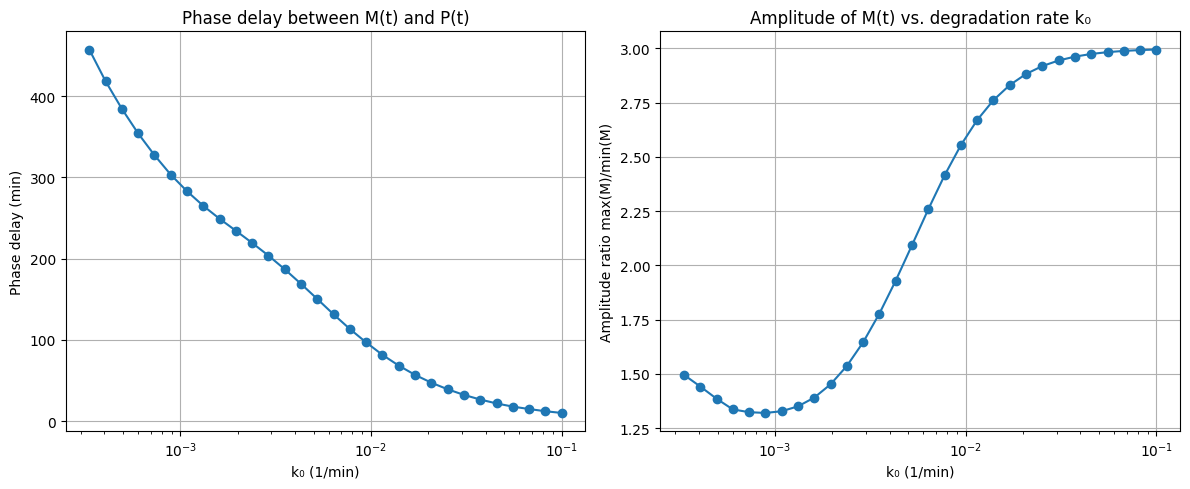

In [50]:
k0_values = np.logspace(np.log10(1/10), np.log10(1/3000), 30)


phase_delays = []
amplitudes = []


# ----------- Loop over different k0 --------------

for k0 in k0_values:

    sol = odeint(production_decay_ode,initial_conditions,time,args=(0.4,1200,5,0.5,k0,0,0))

    P = sol[:,0]
    M = sol[:,1]

    # peak times
    tP = get_peak_time(P, time)
    tM = get_peak_time(M, time)

    # phase delay
    phase_delays.append(tM - tP)

    # amplitude ratio of M
    amplitudes.append(amplitude_ratio(M))


plt.figure(figsize=(12,5))

# Phase delay plot
plt.subplot(1,2,1)
plt.plot(k0_values, phase_delays, 'o-')
plt.xscale('log')
plt.xlabel("k₀ (1/min)")
plt.ylabel("Phase delay (min)")
plt.title("Phase delay between M(t) and P(t)")
plt.grid(True)

# Amplitude plot
plt.subplot(1,2,2)
plt.plot(k0_values, amplitudes, 'o-')
plt.xscale('log')
plt.xlabel("k₀ (1/min)")
plt.ylabel("Amplitude ratio max(M)/min(M)")
plt.title("Amplitude of M(t) vs. degradation rate k₀")
plt.grid(True)

plt.tight_layout()
plt.show()

When the degradation rate k0 is high, meaning that mRNA is removed from the cell very quickly, the mRNA concentration responds almost immediately to changes in pre-mRNA. Because mRNA cannot accumulate over long periods, its peak occurs very shortly after the peak of P(t), leading to a very small phase delay between the two curves. When k0 is low and degradation is slow, mRNA persists for longer and continues to accumulate even after P(t) has begun to decline. As a result, the maximum of M(t) occurs much later, creating a markedly larger phase delay.

To evaluate the strength of oscillations in mRNA concentration, we used the amplitude ratio defined as the maximum value of M(t) divided by its minimum value during the steady oscillatory regime. When k0 is high and mRNA is degraded quickly, the transcript cannot build up to high concentrations, and the resulting oscillations have a small amplitude. When k0 is low and degradation is slow, mRNA accumulates more strongly during each cycle and reaches higher peak levels, which leads to a large amplitude ratio. Biologically, this illustrates how mRNA stability shapes gene expression dynamics: unstable mRNAs produce small, rapid fluctuations, while stable mRNAs generate larger and more pronounced oscillations because they are retained in the cell for longer.

3. Now introduce periodic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a periodic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 

In [ ]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 3000, 10001)

interact(
    animate,
    initial_conditions=fixed(initial_conditions),
    time=fixed(time),
    s0=(1, 10.0, 0.01),
    eps_s=(0.0, 1.0, 0.01),
    k0=(1/3000,1/10, 0.0001),
    eps_k=(0.0, 1.0, 0.01),
    rho=(1/30, 1, 0.05),
    tk=(0.0, 200.0, 0.1),
    T=fixed(1200)
)

interactive(children=(FloatSlider(value=0.4, description='rho', max=1.0, min=0.03333333333333333, step=0.05), …

<function __main__.animate(initial_conditions, time, rho=0.4, s0=5, eps_s=0.5, k0=0.05, eps_k=0.0, tk=0.0, T=1200)>

Even when the transcription rate is constant ($\epsilon_s=0$), mRNA levels can oscillate if the degradation rate varies periodically ($\epsilon_s>0$). During periods of low degradation, mRNA accumulates, and when degradation is high, it is removed more rapidly. This generates oscillatory mRNA dynamics that follow the rhythm of the degradation rate rather than the transcription rate. However since in this model, pre-mRNA is not degraded following $k_t$ law, its concentration doesn't oscillate.

Biologically, this shows that rhythmic gene expression can be controlled post-transcriptionally. Cells can produce oscillations in mRNA abundance without needing periodic transcription, relying instead on timed changes in mRNA stability or degradation activity. The amplitude and timing of these oscillations are determined by the strength and phase of the degradation variations, allowing precise control of mRNA dynamics in coordination with the cell cycle.

### Exercise 2: Cell cycle (post-)transcriptional regulation of gene expression in human RPE1 cells

In this exercise, we will analyze RNA-seq data from normally dividing human RPE1 cells (cell cycle period of $T=20h$).
 The provided data has two replicates and is binned into 50 equally spaced time points ($dt=0.4h=24min$). Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels.
Note that the data are already normalized.
The time has been defined such that $t=0$ corresponds to the start of $G_{1}$. Assume that there is no $G_{0}$ state.

### Function definition

In [2]:

def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, offset=0.1, std_div=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    data=np.log2(data+offset).to_numpy()
    # Scale each sample of the data by mean and by standard deviation if specified
    if scale_data:
        data[:, :50]=data[:, :50]-data[:, :50].mean(1).reshape(-1, 1)
        data[:, 50:]=data[:, 50:]-data[:, 50:].mean(1).reshape(-1, 1)
        if std_div:
            data[:, :50]=data[:, :50]/data[:, :50].std(1).reshape(-1, 1)
            data[:, 50:]=data[:, 50:]/data[:, 50:].std(1).reshape(-1, 1)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    if color_by=="time":
        pca_df[color_by]=np.round(pd.to_numeric(data_tmp.columns.get_level_values(color_by))/50 *20, 1).astype(str)
        palette='twilight'
    else:
        palette='Set1'

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 15))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by) #
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function.

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side intron and exon plots
def plot_gene_expression(dat_melted, gene_name):
    """
    Plots the expression of a gene introns and exons over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['Gene_Symbol'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns

    # Plot Replicate 0 Intron and Exon Expression
    sns.scatterplot(
        data=data[data['replicate'] == "0"],  # Filter directly for intron
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['replicate'] == "0"],  # Filter directly for intron
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Introns and Exons Expression\n Over Time For Replicate 0")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio
    axes[0].set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])

    # Plot Replicate 1 Intron and Exon Expression
    sns.scatterplot(
        data=data[data['replicate'] == "1"],  # Filter directly for intron
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['replicate'] == "1"],  # Filter directly for intron
        x='time', y='expression', hue='feature',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Introns and Exons Expression\n Over Time For Replicate 1")
    axes[1].set_xlabel("Time (hours)")
    axes[1].set_ylabel("Expression Level")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio
    axes[1].set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])


    plt.show()

def best_subplot_shape(n_Genes):
    n_plots=n_Genes
    """
    Return (n_rows, n_cols) giving a near-square layout for n_plots subplots.
    """
    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    return n_rows, n_cols
def plot_gene_list(dat, all_genes_to_plot):
    """
    Plots the levels of the introns and exons of the genes in your list over time.
    """
    exon_0_cols=[c for c in dat.columns.tolist() if ("exon" in c[0] and c[3].split("_")[-1]=="0")]
    intron_0_cols=[c for c in dat.columns.tolist() if ("intron" in c[0] and c[3].split("_")[-1]=="0")]
    exon_1_cols=[c for c in dat.columns.tolist() if ("exon" in c[0] and c[3].split("_")[-1]=="1")]
    intron_1_cols=[c for c in dat.columns.tolist() if ("intron" in c[0] and c[3].split("_")[-1]=="1")]
    n_rows, n_cols=best_subplot_shape(len(all_genes_to_plot))
    #plt.ioff()
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))  # 9 plots (PC1–PC2, ..., PC8–PC9)
    axs = axs.flatten()
    for g_ind, gene in enumerate(all_genes_to_plot):
        ax=axs[g_ind]
        ax_gs = ax.get_subplotspec().subgridspec(2, 1, hspace=0.175)
        plt.delaxes(ax)  # remove the placeholder axes
        ax_ex = fig.add_subplot(ax_gs[1])
        ax_in = fig.add_subplot(ax_gs[0], sharex=ax_ex)
        ax_in.plot(dat.loc[gene, intron_0_cols].to_numpy(), c="orange", label="Introns_rep0")
        #ax_ex=ax.twinx()
        ax_ex.plot(dat.loc[gene, exon_0_cols].to_numpy(), c="red", label="Exons_rep0")
        ax_in.plot(dat.loc[gene, intron_1_cols].to_numpy(), c="lightblue", label="Introns_rep1")
        ax_ex.plot(dat.loc[gene, exon_1_cols].to_numpy(), c="blue", label="Exons_rep1")
        ax_in.set_title(gene)
        ax_ex.set_xlabel("Time [Hr]")
        ax_ex.set_ylabel("Mean counts")
        ax_in.set_ylabel("Mean counts")
        ax_in.set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])
        ax_ex.set_xticks(np.arange(0, 49, 5), np.linspace(0, 20, 11).astype(int)[:-1])
        ax_in.legend()
        ax_ex.legend()

    plt.show()

### Question 1

1. Using the biological knowledge about cell cycle, design a list of 15-20 genes whose mRNA expression profiles should cover all the different phases of the cell cycle.  
For each gene, plot the levels through the cell cycle of both replicates for introns and exons.  
Make sure you get at least one gene peaking in each phase of the cell cycle.  

2. Perform PCA using your list of genes.  
Start by analyzing only the exons, then focus on the introns.
Comment on your observations. 

3. Using these plots (levels of each gene and PCA), provide estimates of when happen $G_{1}/S$ and $G_{2}/M$ transitions. 

4. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression periodicity. Perform this analysis separately for the exons and introns.

- Select periodic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5 for introns and $log_2$ peak-to-trough > 0.25 for exons) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe temporal patterns in gene expression.  

5. What types of genes can you find in the list of periodic genes? Do you recover the genes of the list you designed in 1. ? 




#### Load the RNA-seq data

In [ ]:
dat = pd.read_csv('./pseudobulk.txt', sep='\t', index_col=0)
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','measure','time','replicate'] # name the columns, multi-index
dat=dat.iloc[:, (dat.columns.get_level_values('measure') == "mean")]
dat.head(10)

In [ ]:
#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3], future_stack=True).reset_index()
dat_melted.columns = ['Gene_Symbol', 'feature', 'measure', 'time', 'replicate', 'expression']
dat_melted.head(10)

In [10]:
#Subset the data for intron and exon
idx = pd.IndexSlice
dat_intron = dat.loc[:, idx['intron', 'mean', :, :]]
dat_exon = dat.loc[:, idx['exon', 'mean', :, :]]


#### Plot cell cycle related genes and perform the PCA on them

In [ ]:
#Your currated list of gene
#your_genes_list=[...]

#Plot the genes in your list
#plot_gene_list(...)

#run_PCA ....
#...
#...
#...

#### Assess gene expression periodicity genome-wide

In [15]:
# Apply the function to both intron and exon data.
offset=0.1
dat_intron_fit=dat_intron
dat_exon_fit=dat_exon
dat_intron_fit = np.log2(dat_intron_fit + offset)
dat_exon_fit = np.log2(dat_exon_fit + offset)

T = 20
time = dat_exon_fit.columns.get_level_values('time').str.replace('ZT','').astype(int).to_numpy()
time=time/(time.max()+1)
time=time*T

results_intron = fit_harmo(dat_intron_fit, time, T)
results_exon = fit_harmo(dat_exon_fit, time, T)



#### Define the genes of interest

In [ ]:
# Get the genes with significant periodic gene expression in introns and exons
#genes_per_introns = np.logical_and(..., ...)
#...
#...

#### Plot phase and amplitude distribution for the rhythmic genes

In [ ]:
#...
#...
#...
#...

#### Investigate the types of genes that were selected as periodic

In [ ]:
#...
#...
#...
#...

### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit periodic behaviour at both the pre-mRNA and mRNA levels. Use appropriate cutoffs in your analysis to select a subset of genes that are periodic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times. Explain.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{20}\right) = \frac{2\pi}{20}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives and a scatter plot of half life vs mRNA amplitudes ($log_2$ peak-to-trough). Explain your findings.

4. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

In [ ]:
#plot phase exons vs phase introns
#...
#...


### Plot representative genes with short or long-delay

In [ ]:
#Compute the delay between intron and exon
#Restrict to genes with phase difference < 5 hours and with exon later than intron

#...
#...
#...
#...

#find genes with short delay, plot representative gene expression
#plot_gene_expression(dat_melted, "GeneName")


#find gene with long delay between 3 and 5 hours
 #plot_gene_expression(dat_melted, "GeneName")


### Compute half-life from the delay between intron and exon


In [ ]:
#...
#...
#...
#...

#### Compare Half lives and mRNA amplitudes

In [ ]:
#...
#...
#...
#...